# Validation

This notebook contains examples of some of the simulations that have been used to validate Disimpy's functionality by comparing the simulated signals against analytical solutions. Here, we focus on the monoexponential signal decay in the case of free diffusion and on restricted diffusion in infinite cylinders perpendicular to the diffusion encoding gradient direction. The cylinder simulation is performed with short and long gradient pulses.

In [1]:
# Import the required packages and modules

import numpy as np
import matplotlib.pyplot as plt

from disimpy import gradients, simulations
from disimpy.settings import GAMMA

In [2]:
# Define the simulation parameters

n_s = int(1e6)  # Number of random walkers
n_t = int(1e4)  # Number of time points
diffusivity = 2e-9  # In SI units (m^2/s)

## Free diffusion

Starting simulation
Step length = 2.4519429128950357e-07 m
Step duration = 5.010020040080161e-06 s
Number of spins = 1000000
Number of steps = 10000
Simulation finished.


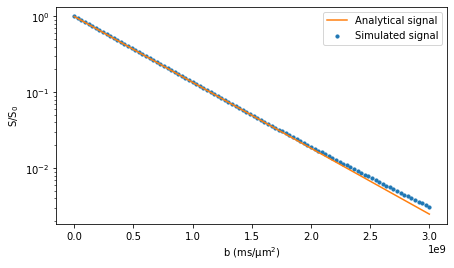

In [3]:
# Create a Stejskal-Tanner gradient array with ∆ = 40 ms and δ = 10 ms

T = 50e-3
gradient = np.zeros((1, 500, 3))
gradient[0, 1:100, 0] = 1
gradient[0, -100:-1, 0] = -1
bs = np.linspace(1, 3e9, 100)
gradient = np.concatenate([gradient for _ in bs], axis=0)
dt = T / (gradient.shape[1] - 1)
gradient, dt = gradients.interpolate_gradient(gradient, dt, n_t)
gradient = gradients.set_b(gradient, dt, bs)


# Run the simulation

substrate = {'type' : 'free'}
signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)


# Plot the results

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.plot(bs, np.exp(-bs * diffusivity), color='tab:orange')
ax.scatter(bs, signals / n_s, s=10, marker='o')
ax.legend(['Analytical signal', 'Simulated signal'])
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
ax.set_yscale('log')
plt.show()

## Restricted diffusion in an infinte cylinder

Starting simulation
Step length = 7.754096504510382e-07 m
Step duration = 5.0105010501050105e-05 s
Number of spins = 1000000
Number of steps = 10000
Simulation finished.


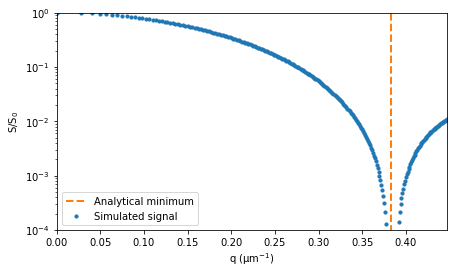

In [12]:
# Create a Stejskal-Tanner gradient array with ∆ = 0.5 s and δ = 1 ms

T = 501e-3
gradient = np.zeros((1, n_t, 3))
gradient[0, 1:20, 0] = 1
gradient[0, -20:-1, 0] = -1
dt = T / (gradient.shape[1] - 1)
bs = np.linspace(1, 1e11, 250)
gradient = np.concatenate([gradient for _ in bs], axis=0)
gradient = gradients.set_b(gradient, dt, bs)
q = gradients.calc_q(gradient, dt)
qs = np.max(np.linalg.norm(q, axis=2), axis=1)


# Run the simulation

radius = 10e-6
substrate = {'type' : 'cylinder',
             'orientation' : np.array([0, 0, 1.0]),
             'radius' : radius}
signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)


# Plot the results and the analytical solution. Please see the paper by Avram
# et al. for details: https://doi.org/10.1002/nbm.1277

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(1e-6 * qs, signals / n_s, s=10, marker='o')
minimum = 1e-6 * .61 * 2 * np.pi / radius
ax.plot([minimum, minimum], [0, 1], ls='--', lw=2, color='tab:orange')
ax.legend(['Analytical minimum', 'Simulated signal'])
ax.set_xlabel('q (μm$^{-1}$)')
ax.set_ylabel('S/S$_0$')
ax.set_yscale('log')
ax.set_ylim([1e-4, 1])
ax.set_xlim([0, max(1e-6 * qs)])
plt.show()

Starting simulation
Step length = 3.481553119113957e-07 m
Step duration = 1.0101010101010101e-05 s
Number of spins = 1000000
Number of steps = 10000
Simulation finished.


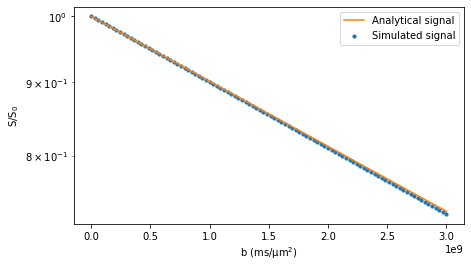

In [7]:
# Create a Stejskal-Tanner gradient array with ∆ = δ = 50 ms

T = 100e-3
gradient = np.zeros((1, 100, 3))
gradient[0, 1:50, 0] = 1
gradient[0, -50:-1, 0] = -1
bs = np.linspace(1, 3e9, 100)
gradient = np.concatenate([gradient for _ in bs], axis=0)
dt = T / (gradient.shape[1] - 1)
gradient, dt = gradients.interpolate_gradient(gradient, dt, n_t)
gradient = gradients.set_b(gradient, dt, bs)


# Calculate the analytical signal prediction using Equation 8 in the
# paper by Assaf et al.: https://doi.org/10.1002/mrm.20274

radius = 7.5e-6
analytical_expression = np.exp(
    - (radius**4 * GAMMA**2 * np.max(gradient, axis=(1, 2))**2 / diffusivity)
    * (7/96) * (T - 99/112 * radius**2 / diffusivity)) 


# Run the simulation

substrate = {'type' : 'cylinder',
             'orientation' : np.array([0, 0, 1.0]),
             'radius' : radius}
signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)


# Plot the results

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.plot(bs, analytical_expression, color='tab:orange')
ax.scatter(bs, signals / n_s, s=10, marker='o')
ax.legend(['Analytical signal', 'Simulated signal'])
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
ax.set_yscale('log')
plt.show()